## Project Note ##

**This project uses BERT for converting texts to embeddings and incorporated GPU support**

*GPU: GeForce GTX 1080*  
*Runtime: approximately 26 minutes total for training and test feature generation*

### Introduction ###

In this project, we'll develop a system for filtering and categorizing movie reviews using sentiment analysis. The goal is to train a model to automatically detect negative reviews. We'll be using a dataset of IMBD movie reviews with polarity labeling to build a model for classifying positive and negative reviews. Our evaluation goal is to achieve an F1 score of at least 0.85.

### Initialization ###

In [1]:
import math
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
import spacy
import torch
import transformers

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn-v0_8')

# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

### Load and Inspect Data ###

In [3]:
# When cloning this project, ensure directory/file paths are correct with respect to user's operating system
df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

display(df_reviews.sample(10))
df_reviews.info()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
891,tt0295289,movie,A Guy Thing,A Guy Thing,2003,\N,101,0,"Comedy,Romance",5.6,16354,Oh-so-familiar comedy story about low-key nice...,3,neg,0,train,3867
34621,tt0052619,movie,The Best of Everything,The Best of Everything,1959,\N,121,0,"Drama,Romance",6.5,1756,Fun bad movie which should amuse. One of Joan ...,8,pos,1,test,3304
40941,tt0144814,movie,The Rage: Carrie 2,The Rage: Carrie 2,1999,\N,104,0,"Horror,Sci-Fi,Thriller",4.7,15201,I thought that this movie lacked the building...,3,neg,0,test,4611
31071,tt0141831,short,Skeleton Frolic,Skeleton Frolic,1937,\N,7,0,"Animation,Comedy,Horror",6.8,172,Having just seen Walt Disney's The Skeleton Da...,9,pos,1,test,176
37589,tt0071583,movie,The Groove Tube,The Groove Tube,1974,\N,75,0,Comedy,5.9,1879,"With the current trend of gross out humor, thi...",7,pos,1,train,6865
30463,tt0300470,video,Shakedown,Shakedown,2002,\N,92,0,"Action,Drama",4.9,299,"An average TV movie quality, totally formula s...",3,neg,0,train,7362
14247,tt0751129,tvEpisode,Gender Bender,Gender Bender,1994,\N,45,0,"Crime,Drama,Mystery",7.5,3998,This episode from the first season slightly ed...,8,pos,1,train,7558
7180,tt0037595,movie,Christmas in Connecticut,Christmas in Connecticut,1945,\N,101,0,"Comedy,Romance",7.4,7429,I came across this movie back in the mid eight...,10,pos,1,test,1055
12360,tt0182576,tvSeries,Family Guy,Family Guy,1999,\N,22,0,"Animation,Comedy",8.1,296907,Have you ever seen one of those shows that bec...,2,neg,0,test,2595
63,tt0499603,movie,10 Items or Less,10 Items or Less,2006,\N,82,0,"Comedy,Drama",6.6,14062,10 ITEMS OR LESS was made in two weeks on a sh...,8,pos,1,train,4957


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

### EDA ###

Let's check the number of movies and reviews over years.

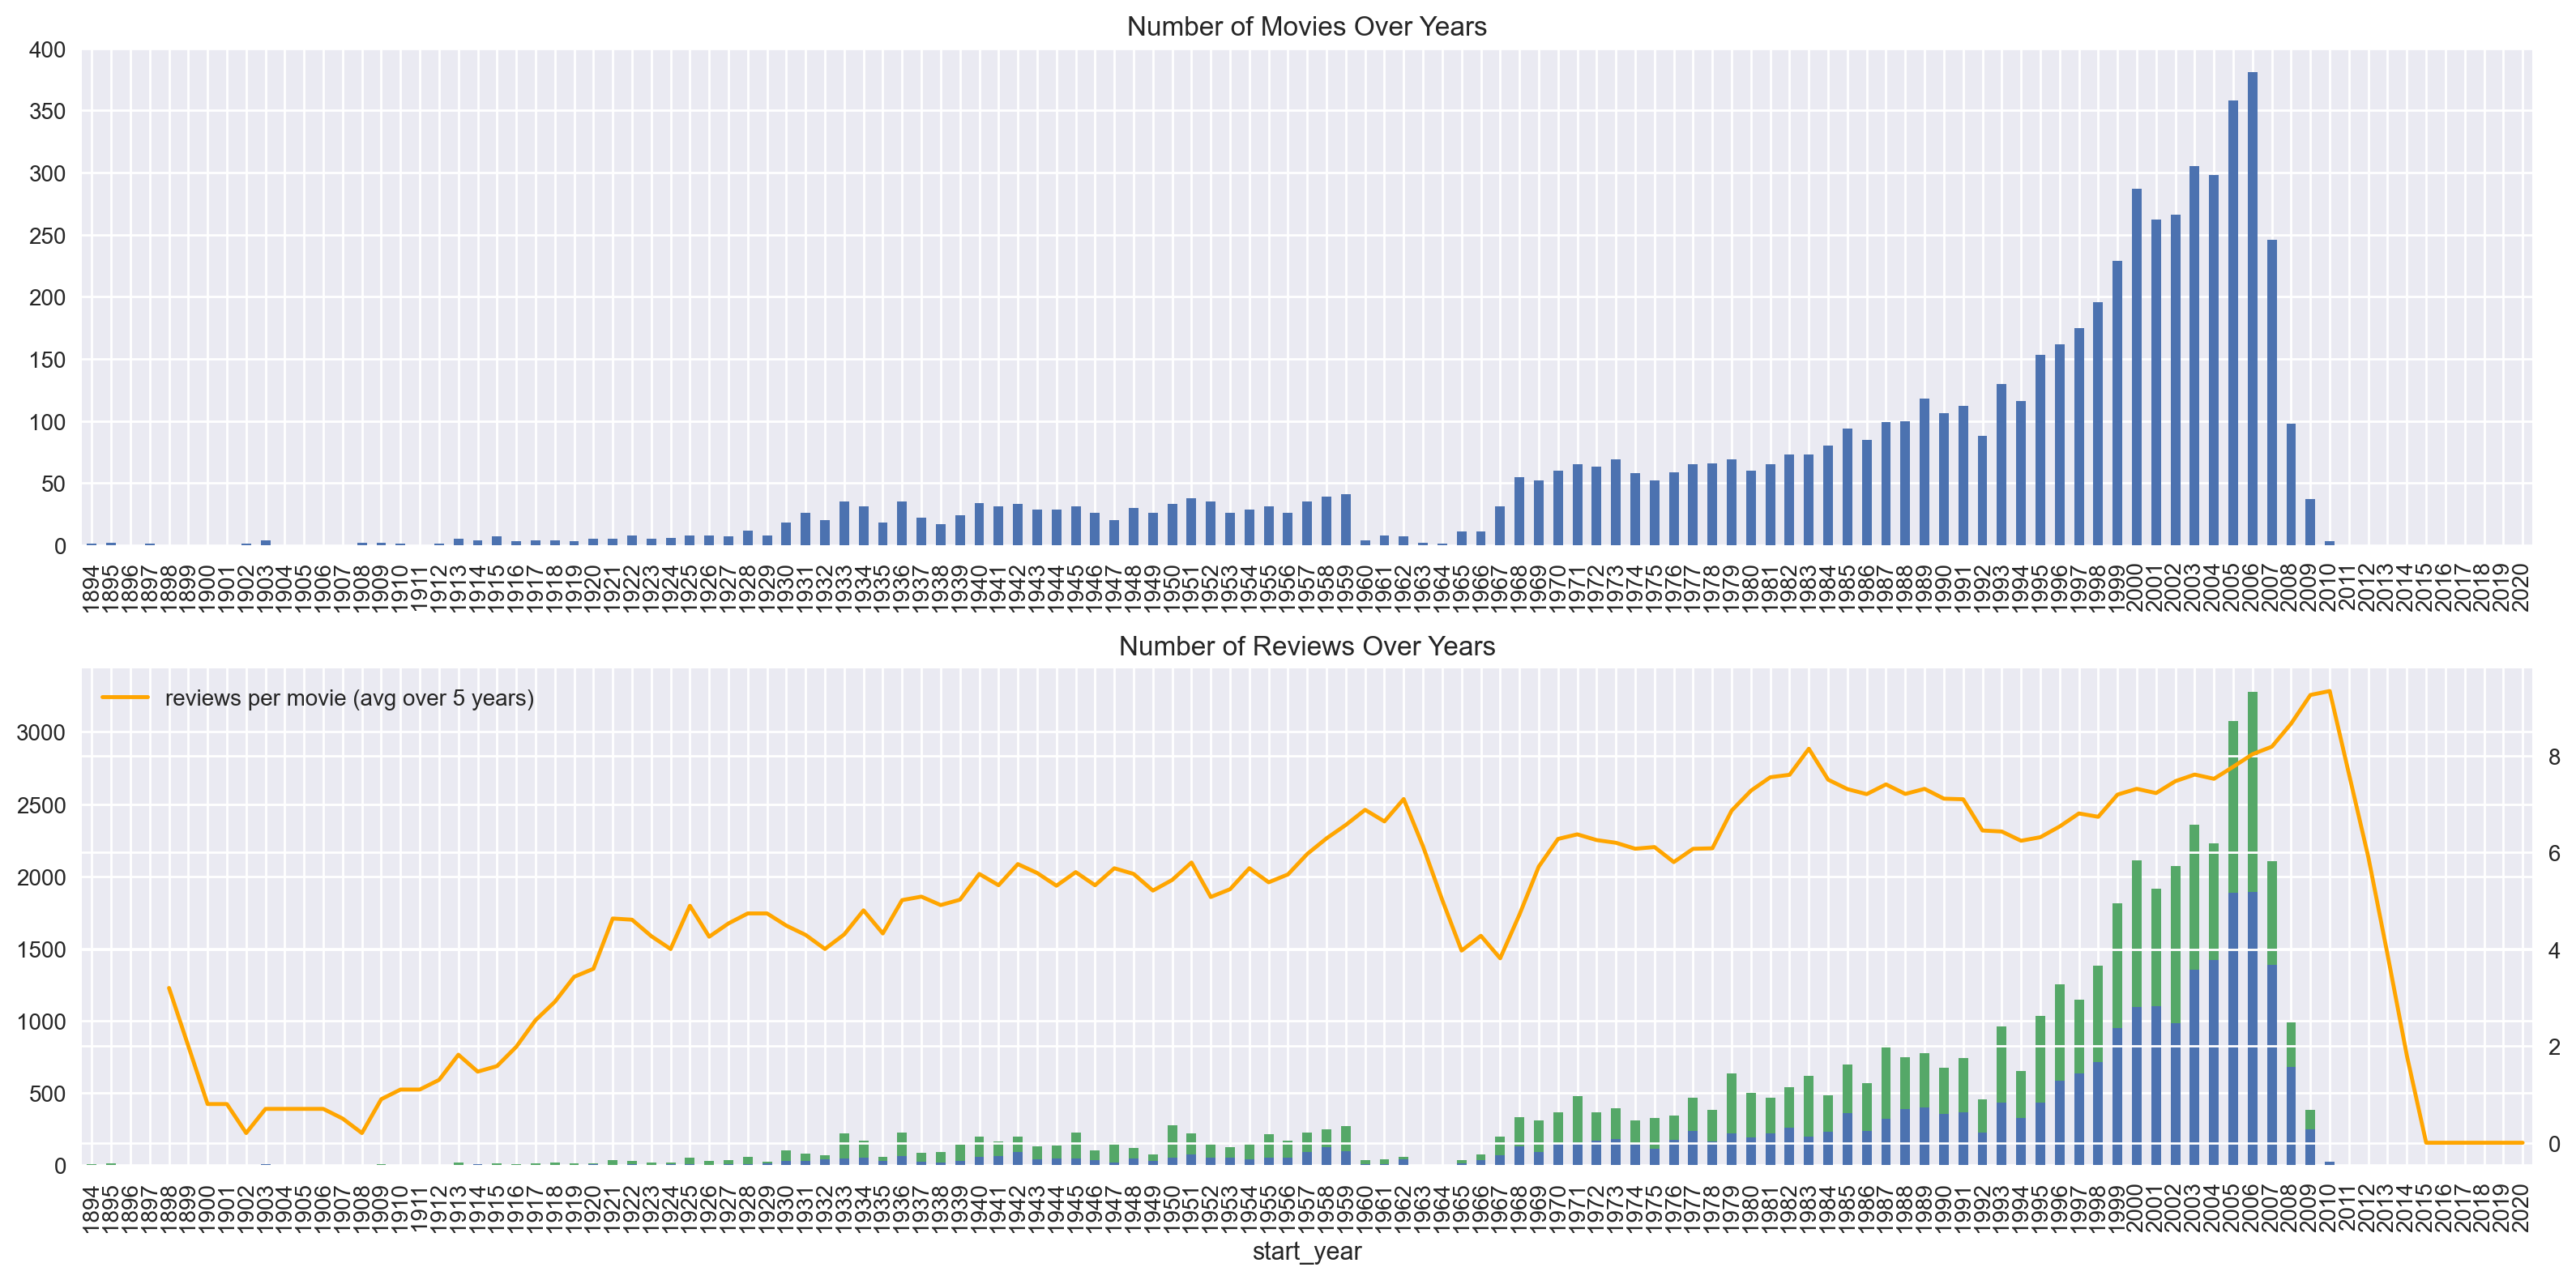

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

From the dataset, we can see the number of movies and number of reviews increased over time, with what appears to be the majority of movies in the 2000s. Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

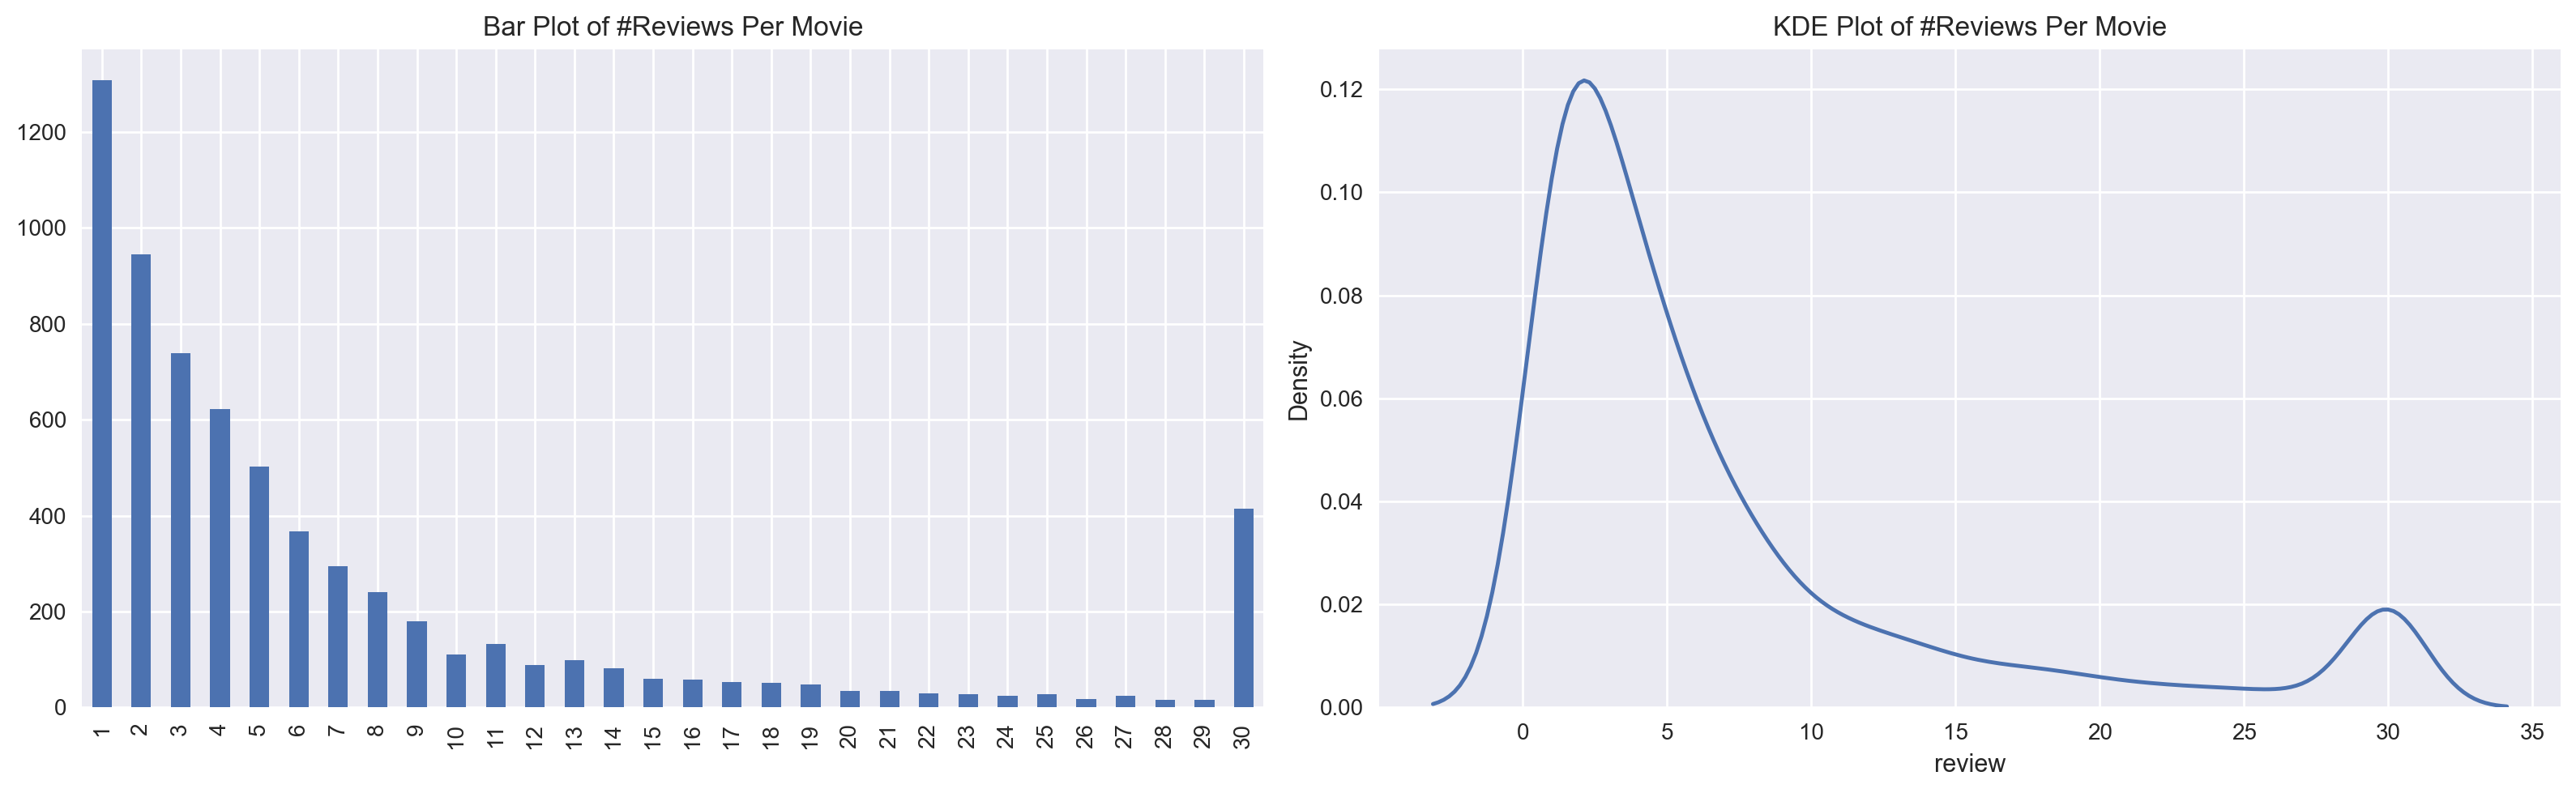

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [6]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

The class values appear to be fairly balanced with almost the same number of positive and negative reviews. In terms of number of reviews, most of the movies have between 1 and 5 reviews with a small percentage of movies having more than 25 reviews.

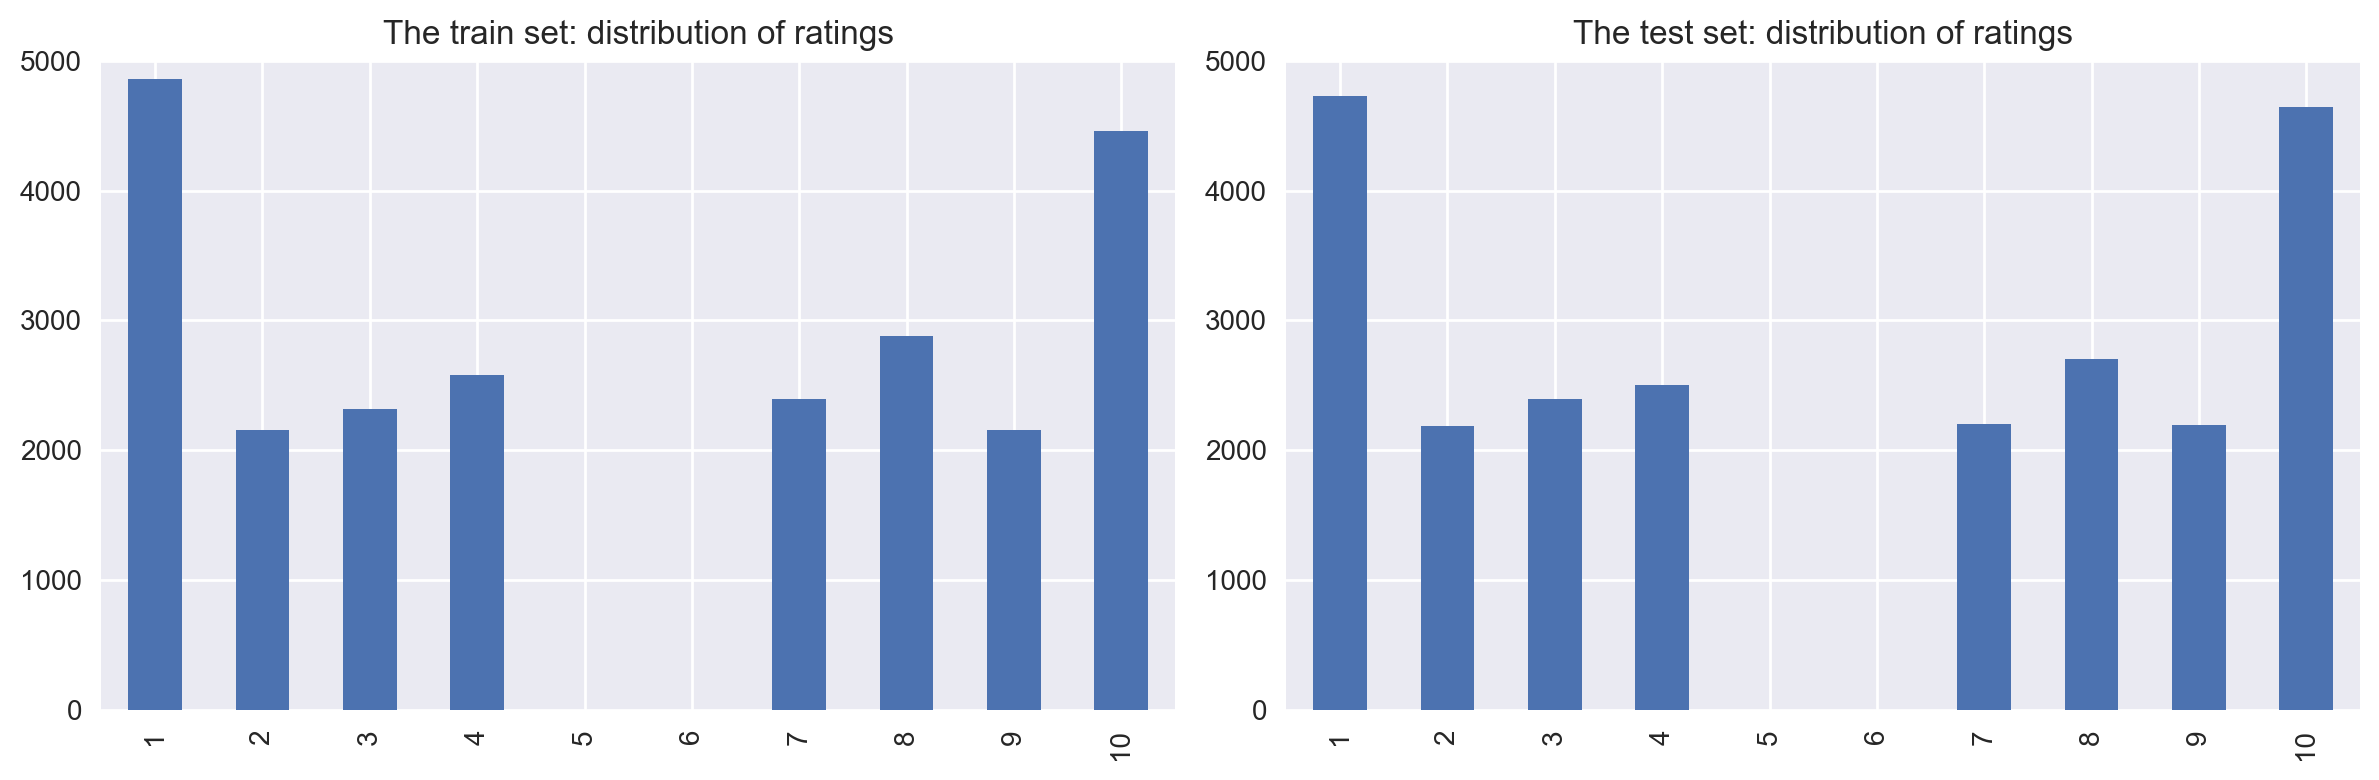

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset. Of note, the training and test sets appear to have similar distributions.

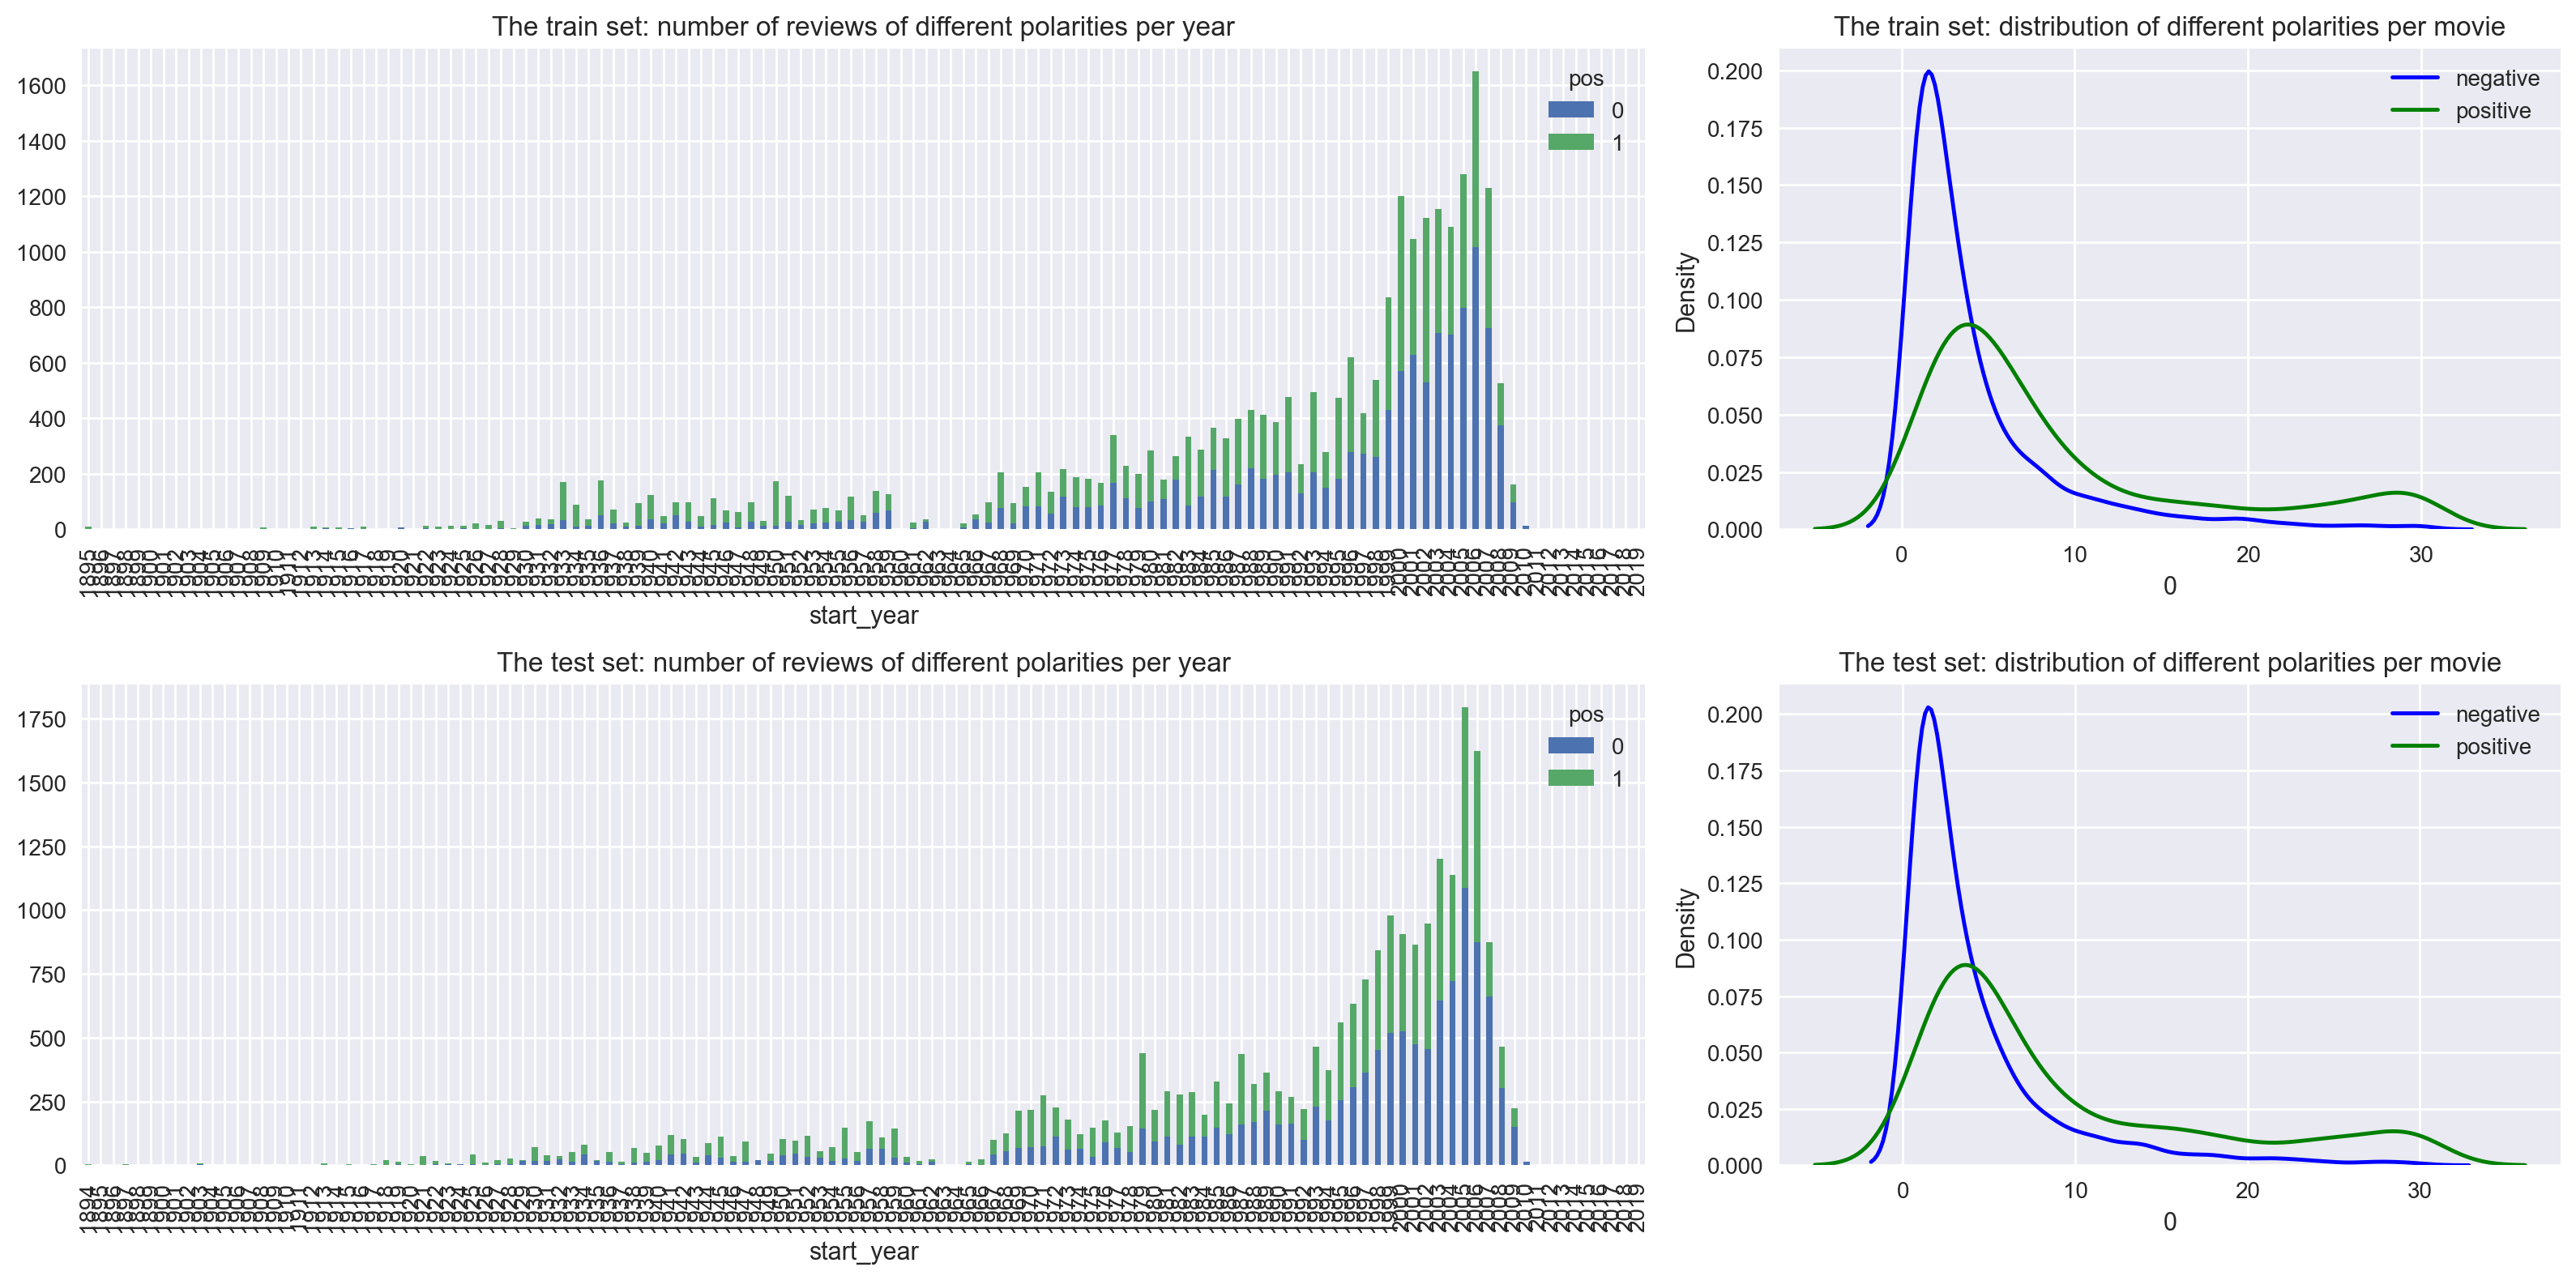

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

### Evaluation Procedure ###

Composing an evaluation routine which can be used for all models in this project.

In [9]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

### Normalization ###

We assume all models below accepts texts in lowercase and without any digits or punctuations marks. We'll define the function, *clean_string( )*, to filter the reviews:

**Parameters**  
- *text*: String containing a movie review to be processed.

**Returns**: The movie review with numbers, punctuation, and extra spaces removed, converted to lowercase.

In [10]:
def clean_string(text):
    s = re.sub(r"[^a-zA-Z']", ' ', text)
    return (' '.join(s.split())).lower()

We'll add a column of the processed reviews which will be used for vectorization/feature creation. We'll print five samples to ensure the filter processed correctly.

In [11]:
df_reviews['review_norm'] = df_reviews['review'].apply(clean_string)
display(df_reviews['review_norm'].sample(5))

5562     i cant explain what a load of rubbish this fil...
45254    this is by far the worst and most stupid show ...
29553    what a joy to watch this family grow up and se...
2395     paris is the place to be to enjoy beautiful ar...
14221    in a farcical key gaud afternoons can be taken...
Name: review_norm, dtype: object

### Splitting the Dataset ###

The whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [12]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


### Working with Models ###

Reviews will be vectorized by calculating the TF-IDF (or embeddings for BERT model). The prediciton models we'll compare are as follows:
- LogisticRegression with NLTK derived lemmas
- LogisticRegression with spaCy dervied lemmas
- LGBMClassifier with spaCy derived lemmas
- LogisticRegression with BERT

Additionally, we'll establish a baseline using a constant model.

**Constant Model**

The constant model will always predict a positive (i.e. 1) review.

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


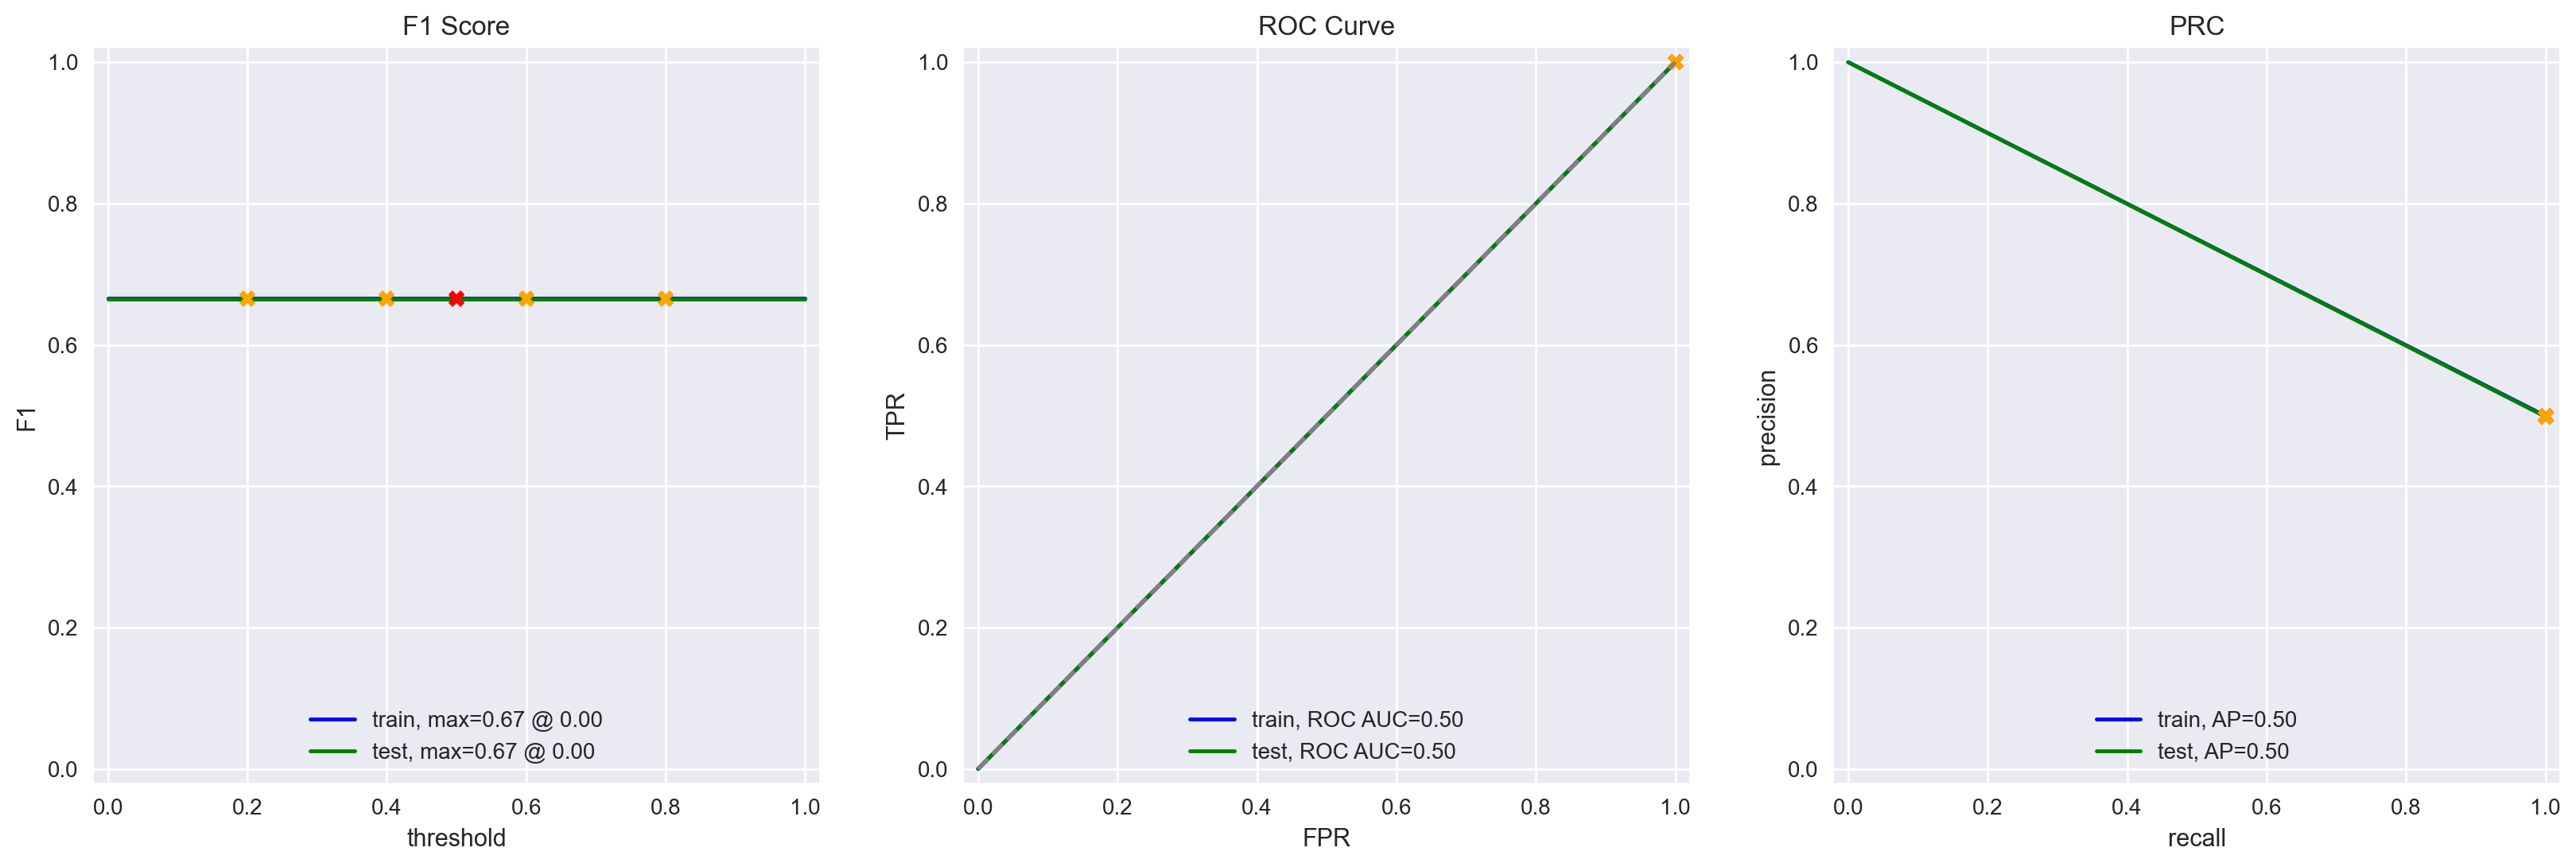

In [13]:
train_features = np.ones(train_target.shape)
test_features = np.ones(test_target.shape)

dummy = DummyClassifier(strategy='constant', random_state=12345, constant=1)
dummy.fit(train_features, train_target)

evaluate_model(dummy, train_features, train_target, test_features, test_target)

**NLTK, TF-IDF, and LogisticRegression**

We'll define the function, *nltk_lemma_processor( )*, to lemmatize each review using the NLTK library, as follows:

**Parameters**
- *text*: String of the review to be lemmatized using NLTK.

**Returns**: String of the joined lemmas.

In [14]:
def nltk_lemma_processor(text):
    lemmatizer  = WordNetLemmatizer()
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(lemmas) 

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


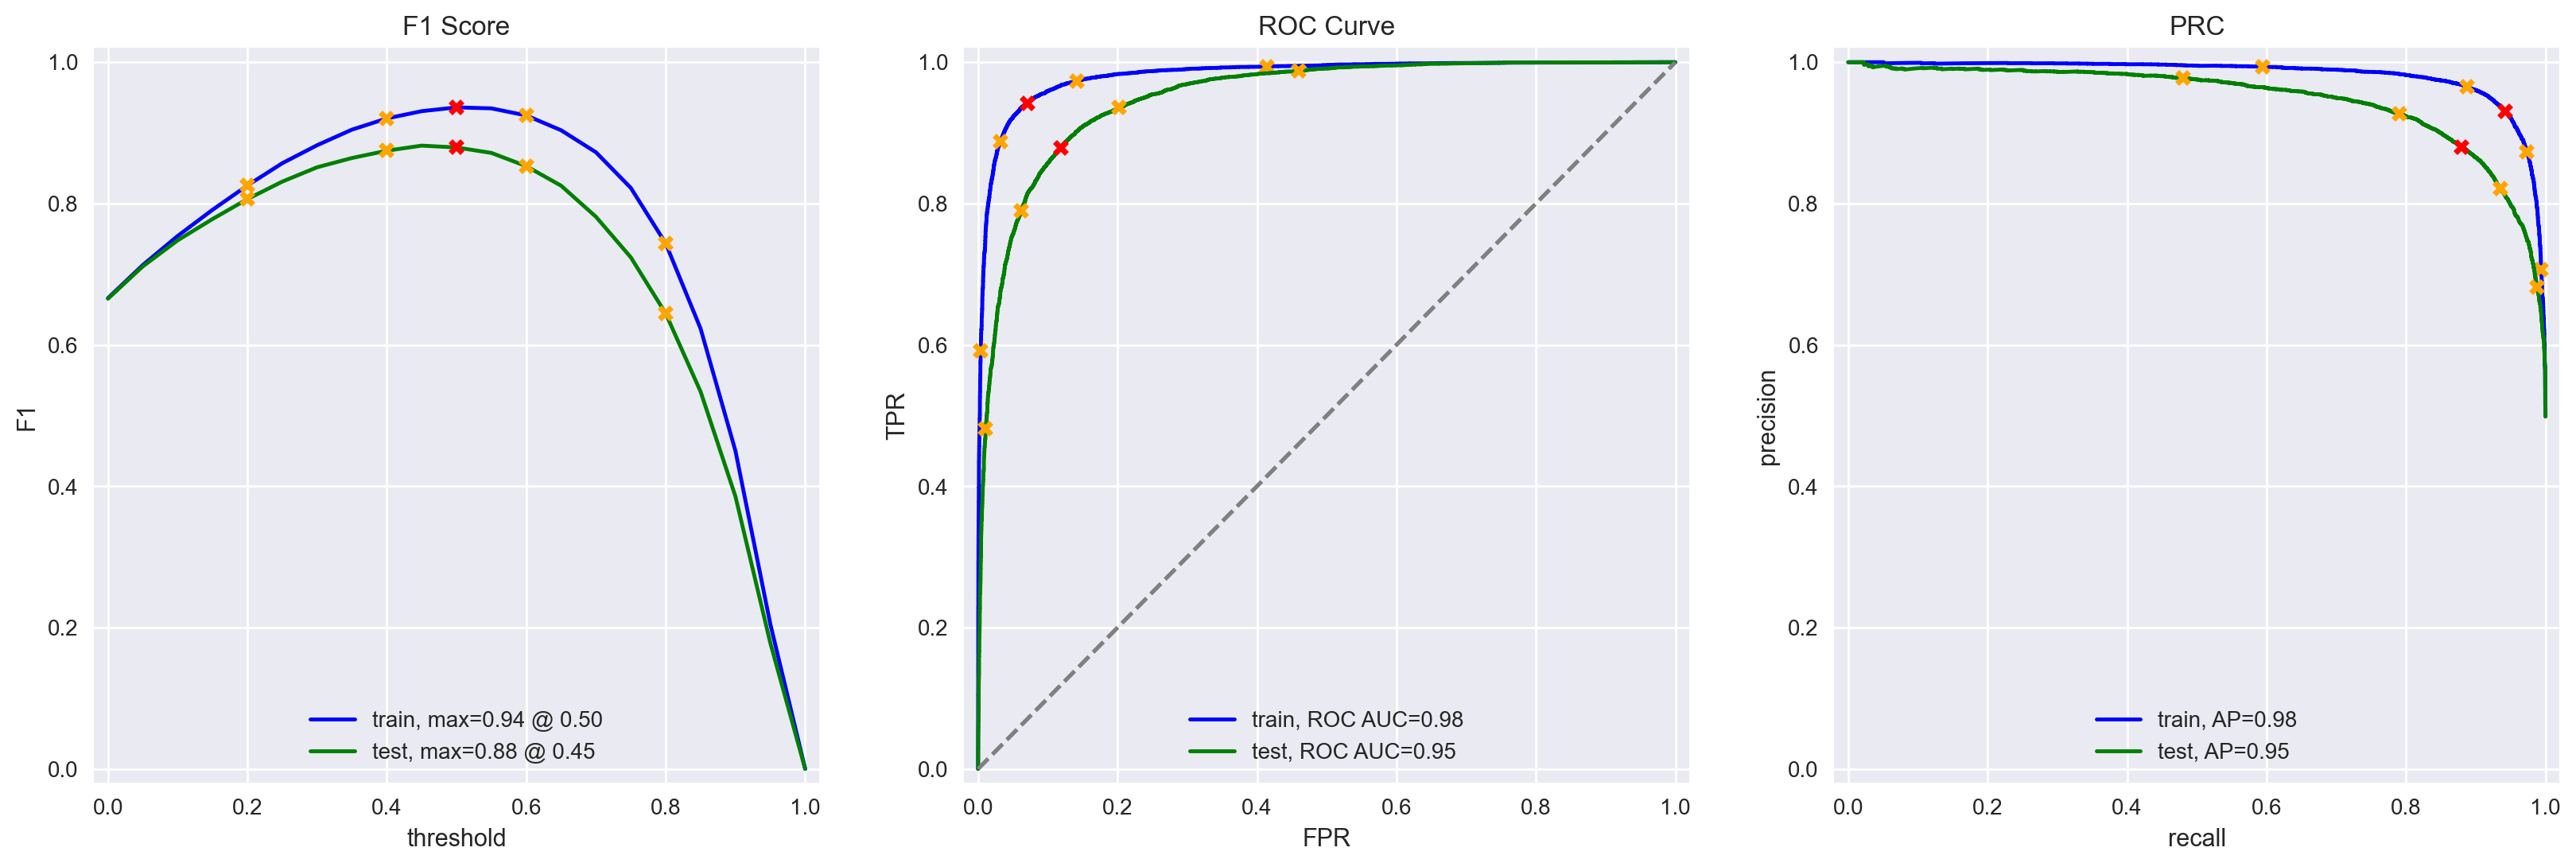

In [15]:
df_reviews_train['nltk_lemma'] = df_reviews_train['review_norm'].apply(nltk_lemma_processor)
df_reviews_test['nltk_lemma'] = df_reviews_test['review_norm'].apply(nltk_lemma_processor)

count_tf_idf = TfidfVectorizer(stop_words=stopwords.words('english'))
nltk_tf_idf = count_tf_idf.fit(df_reviews_train['nltk_lemma'])

train_features = nltk_tf_idf.transform(df_reviews_train['nltk_lemma'])
test_features = nltk_tf_idf.transform(df_reviews_test['nltk_lemma'])

lr_model_nltk = LogisticRegression(random_state=12345, solver='liblinear')
lr_model_nltk.fit(train_features, train_target)

evaluate_model(lr_model_nltk, train_features, train_target, test_features, test_target)

The logistical regression model using the NLTK dervied lemmas performed well on the training set, but appeared to be slightly overfit when evaluated against the test set. The model still acheived a score above the F1 score threshold with a 0.88.

**spaCy, TF-IDF, and LogisticRegression**

We'll first load the small-szie English model spaCy pipline to process the reviews.

In [16]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


Similar to the NLTK lemmatization function, we'll define, *spacy_lemma_processor( )*, to faciliate converting tokens into lemmas using spaCy:

**Parameters**
- *text*: String of the review to be lemmatized using spaCy.

**Returns**: String of the joined lemmas.

In [17]:
def spacy_lemma_processor(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
          
    return ' '.join(tokens)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.95


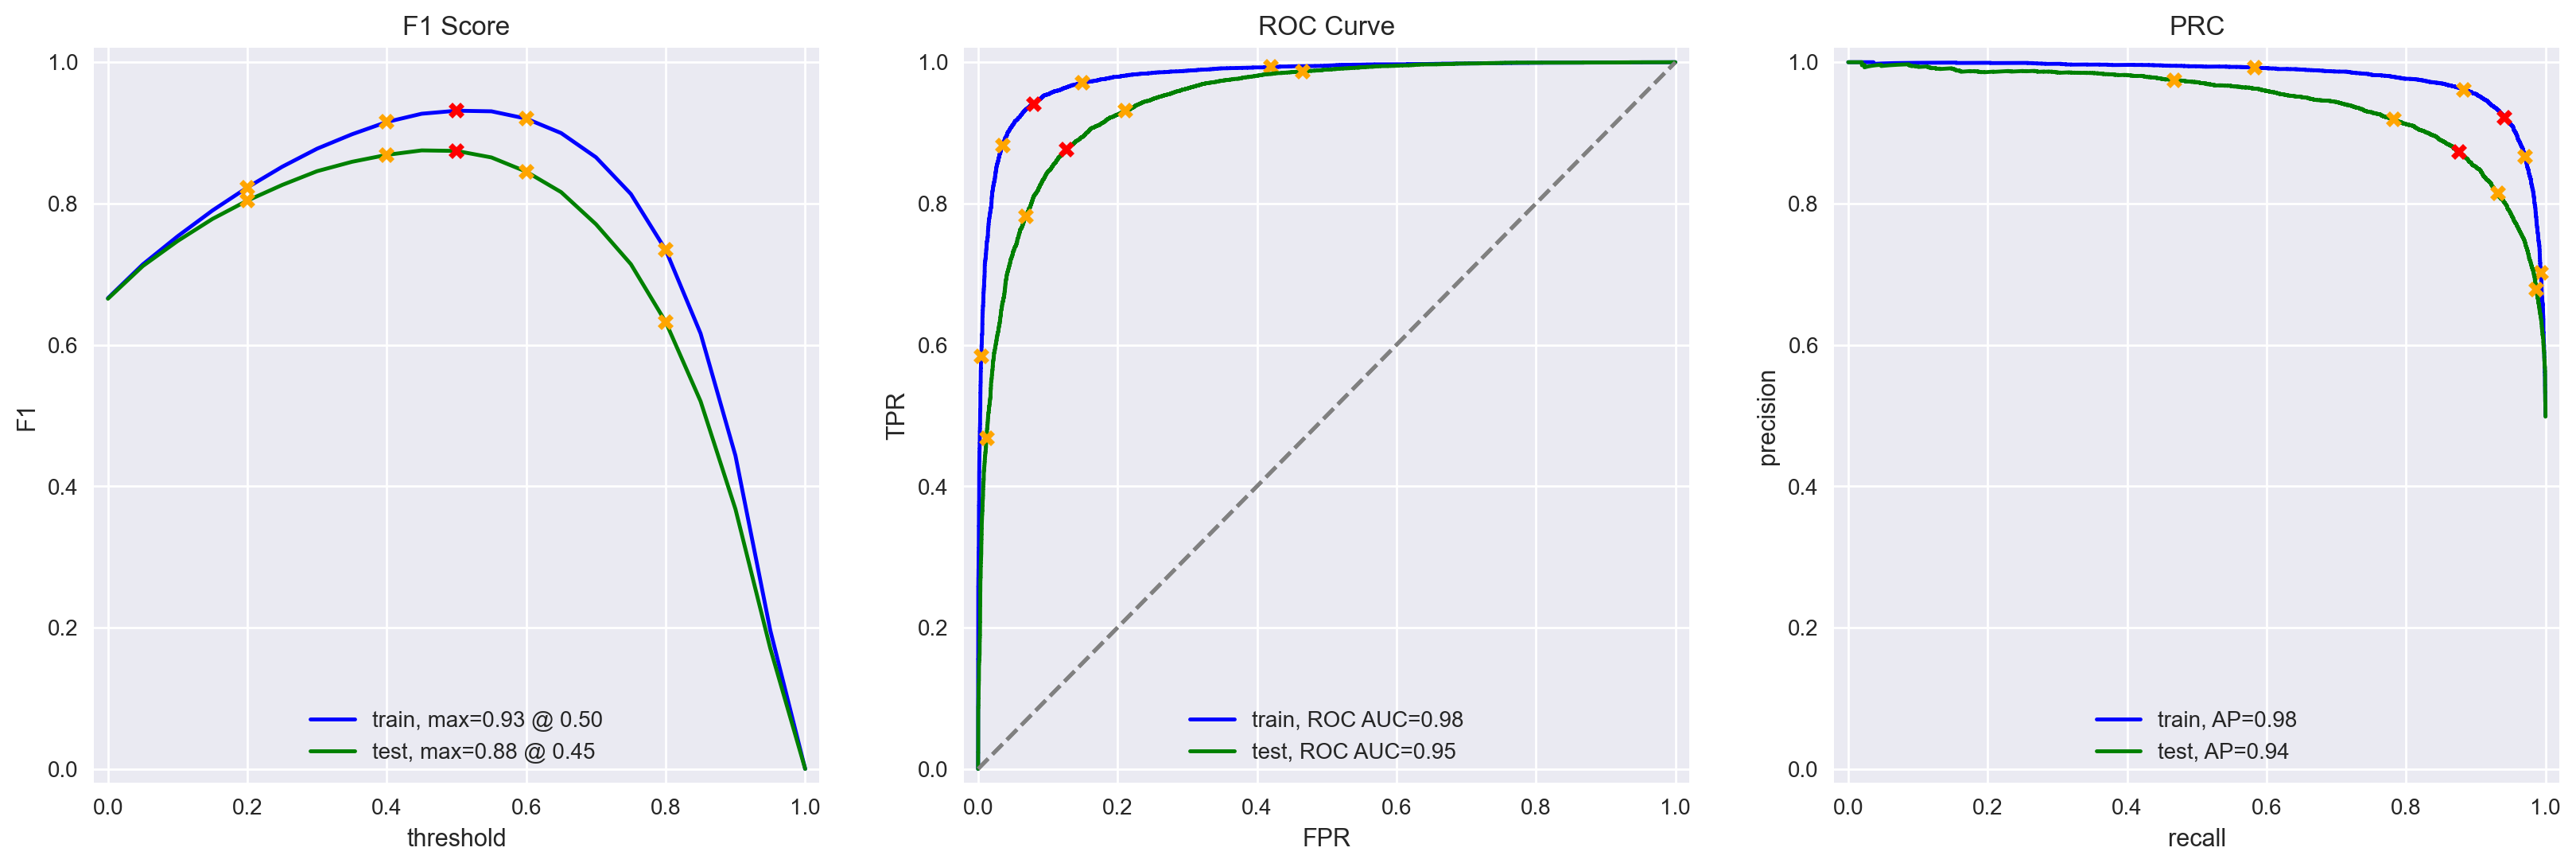

In [18]:
df_reviews_train['spacy_lemma'] = df_reviews_train['review_norm'].apply(spacy_lemma_processor)
df_reviews_test['spacy_lemma'] = df_reviews_test['review_norm'].apply(spacy_lemma_processor)

count_tf_idf = TfidfVectorizer()
spacy_tf_idf = count_tf_idf.fit(df_reviews_train['spacy_lemma'])

train_features = spacy_tf_idf.transform(df_reviews_train['spacy_lemma'])
test_features = spacy_tf_idf.transform(df_reviews_test['spacy_lemma'])

lr_model_spacy = LogisticRegression(random_state=12345, solver='liblinear')
lr_model_spacy.fit(train_features, train_target)

evaluate_model(lr_model_spacy, train_features, train_target, test_features, test_target)

The logistical regression model using the spaCy dervied lemmas appeared to have similar performance, with slightly lower accuracy and F1 scores across both the training and test sets. The model still performed above the F1 score threshold.

**spaCy, TF-IDF, and LGBMClassifier**

We can use the previous lemmas created from spaCy and train the next model.

          train  test
Accuracy   0.91  0.85
F1         0.91  0.85
APS        0.97  0.93
ROC AUC    0.97  0.93


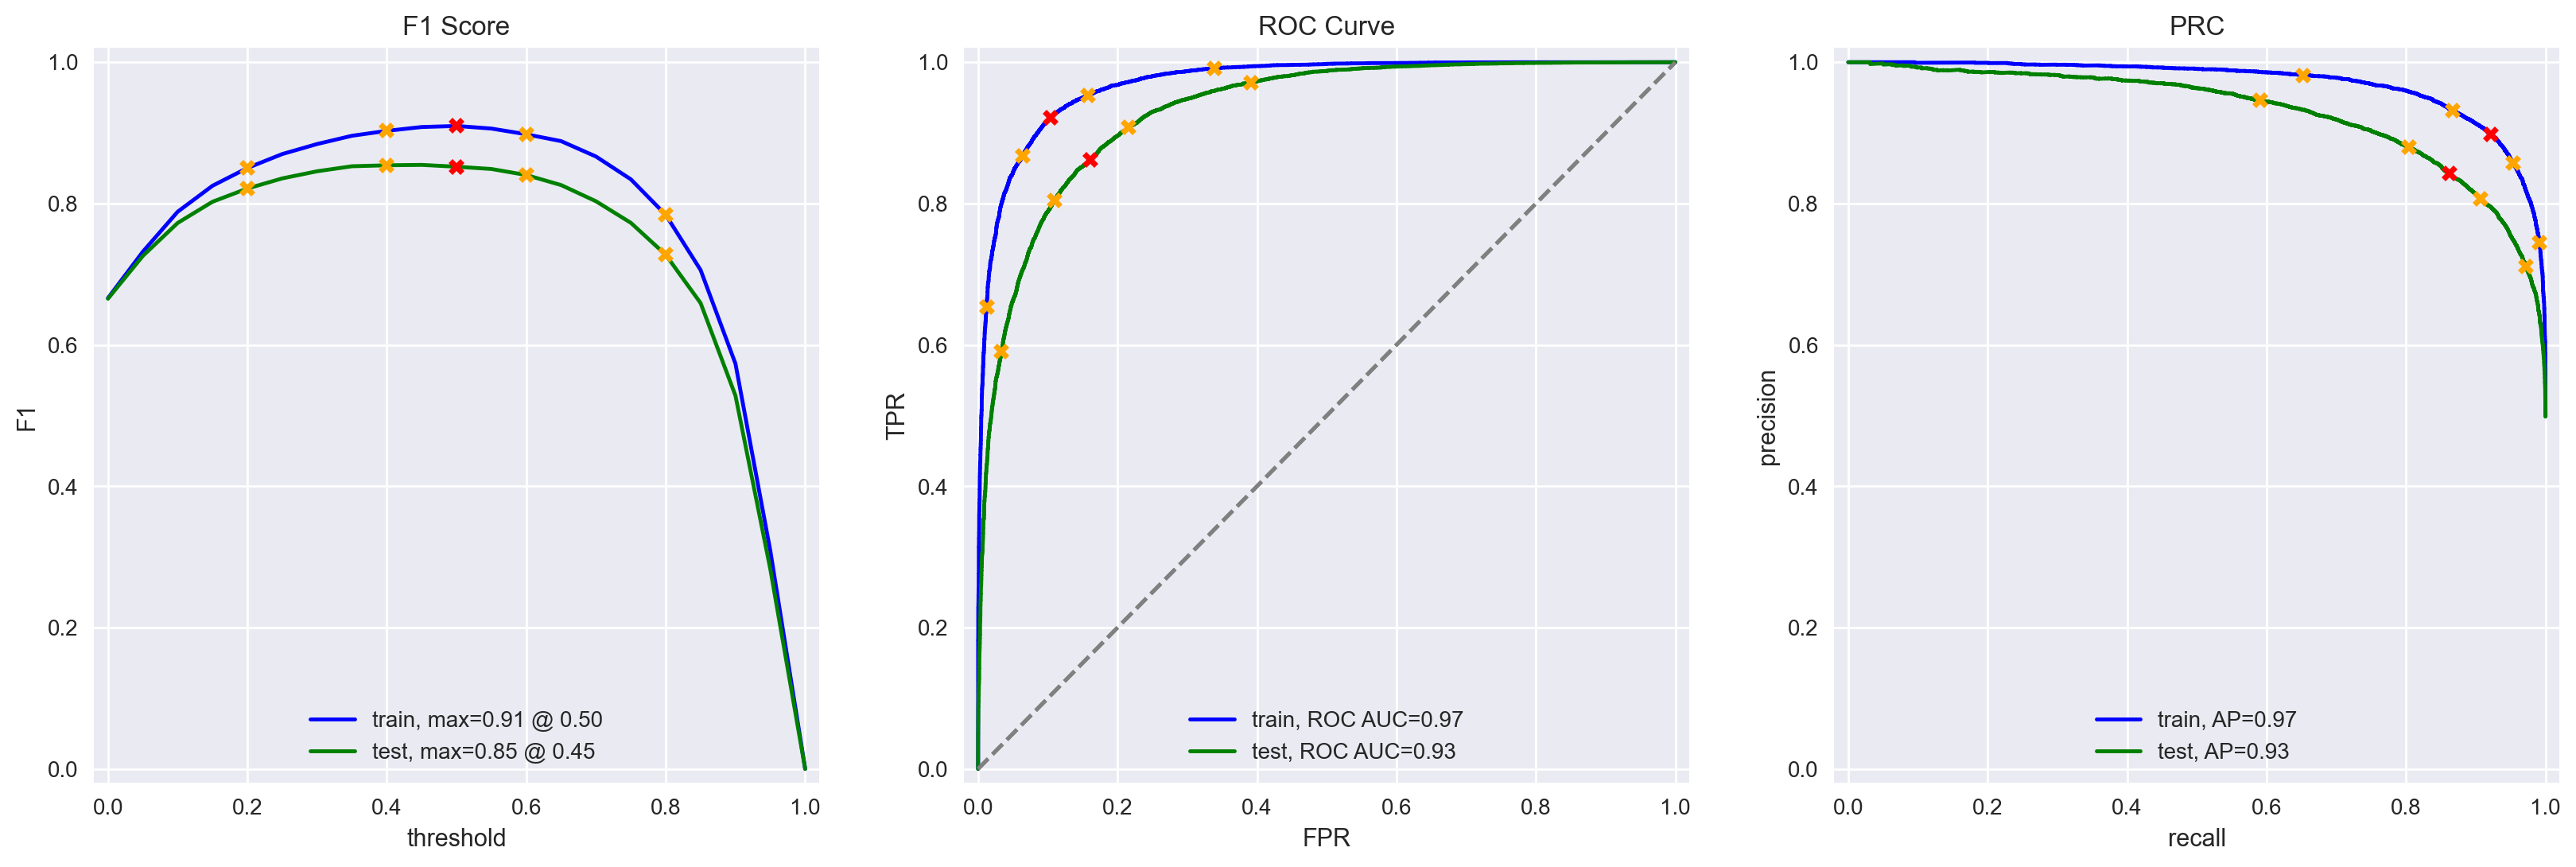

In [19]:
lgbm_model = LGBMClassifier(random_state=12345, n_jobs=-1)
lgbm_model.fit(train_features, train_target)

evaluate_model(lgbm_model, train_features, train_target, test_features, test_target)

The LightGBM classifier still achieved an F1 score that met the threshold requirement, but the overall performance appeared to be lower than the logistical regression models.

**BERT and LogisticRegression**

Initializing BERT tokenizer, configuration, and model.

In [20]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


To facilitate the preprocessing, the function *BERT_text_to_embeddings( )* is defined below:

**Parameters**
- *texts*: String to be tokenized for embeddings.
- *max_length*: Maximum vector length, default value of 512 (BERT maximum).
- *batch_size*: Batch size for embedding creation, default value of 100.
- *force_device*: Force CPU or GPU usage, default None.
- *disable_progress_bar*: Boolean flag to hide or show tqdm visual progress bar, default False.

**Returns**: BERT embeddings to be used as training/test features.

In [21]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks  
    for input_text in texts:
        ids = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # get embeddings in batches
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):        
        ids_batch = torch.LongTensor(np.array(ids_list[batch_size*i:batch_size*(i+1)])).to(device)
        attention_mask_batch = torch.LongTensor(np.array(attention_mask_list[batch_size*i:batch_size*(i+1)])).to(device)

        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

Creating train and test features using BERT embeddings.

In [22]:
train_features_BERT = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')
test_features_BERT = BERT_text_to_embeddings(df_reviews_test['review_norm'], force_device='cuda')

Using the cuda device.


  0%|          | 0/238 [00:00<?, ?it/s]

Using the cuda device.


  0%|          | 0/236 [00:00<?, ?it/s]

          train  test
Accuracy   0.88  0.86
F1         0.88  0.86
APS        0.95  0.94
ROC AUC    0.95  0.94


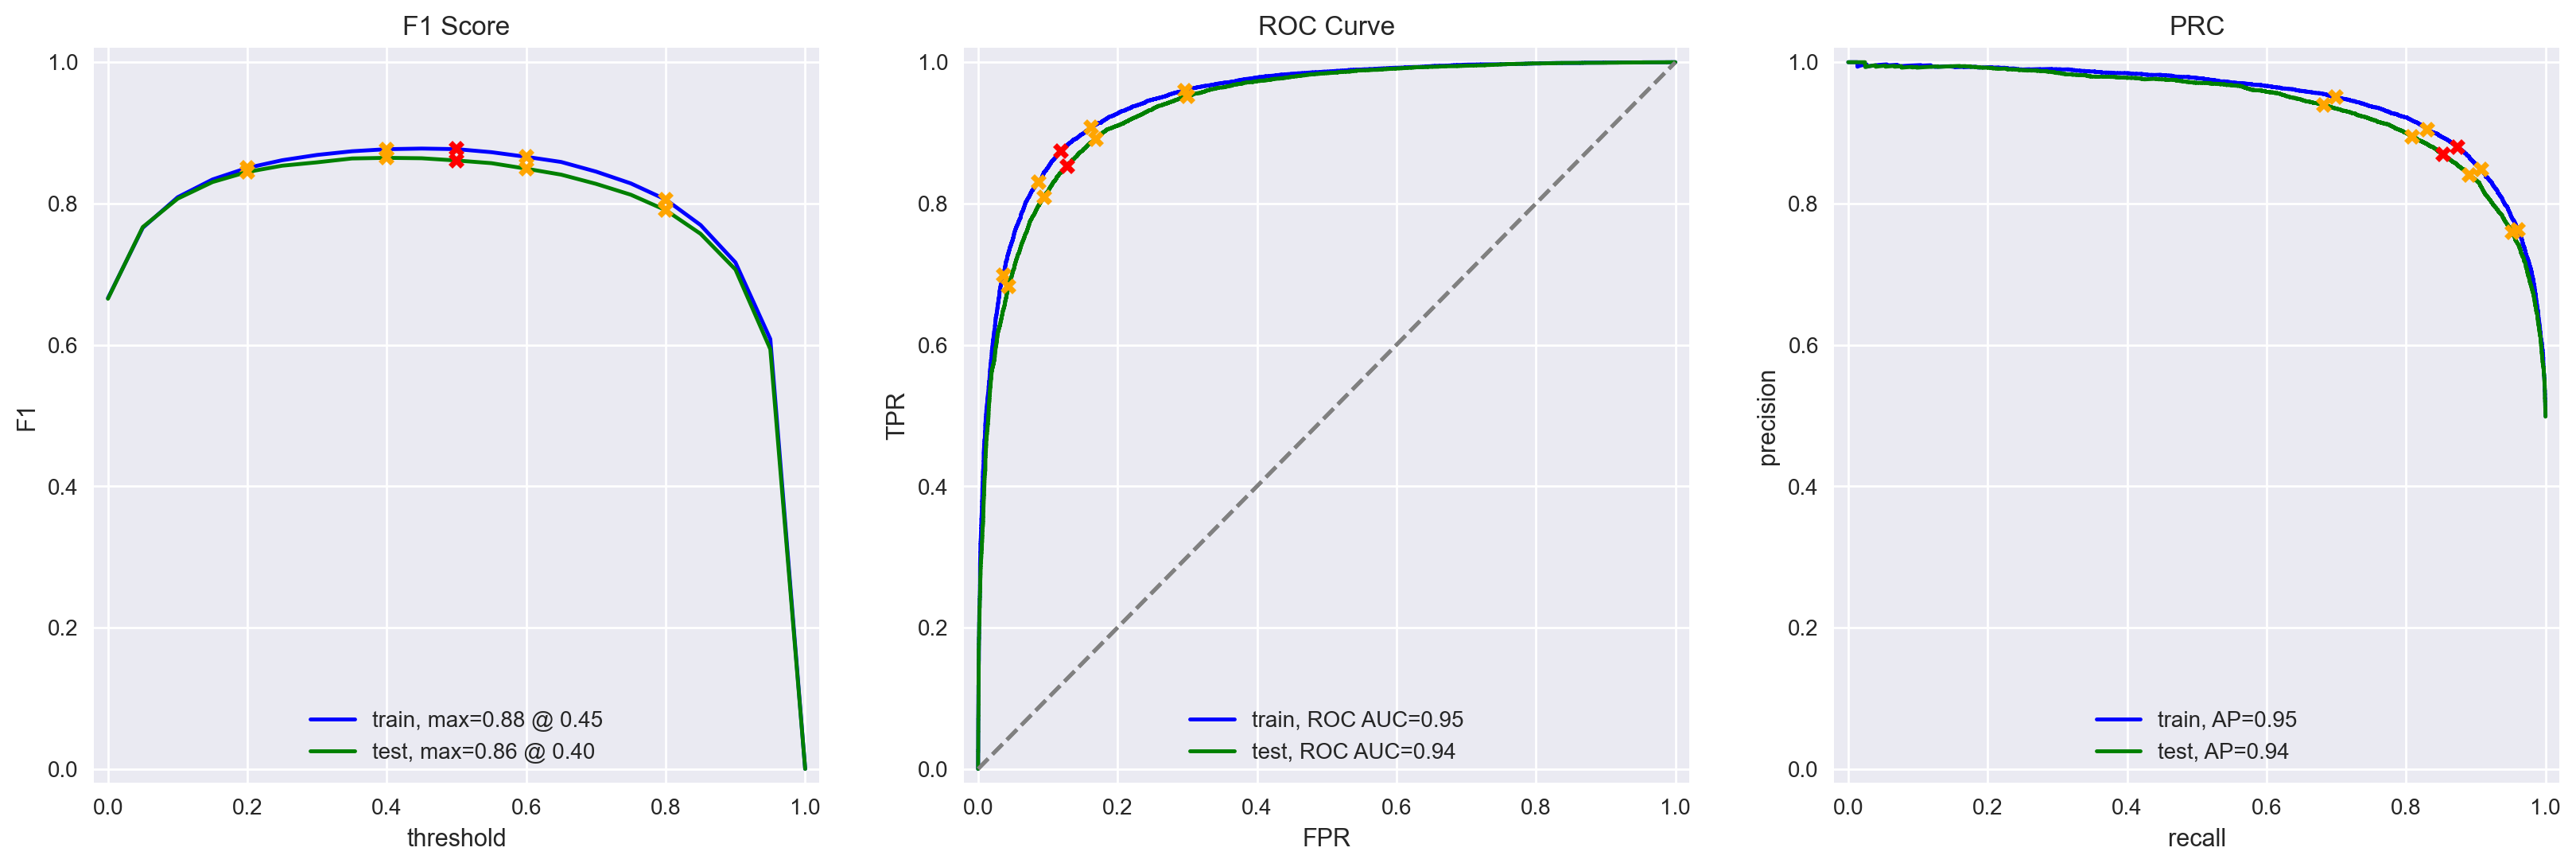

In [23]:
lr_model_BERT = LogisticRegression(random_state=12345, solver='liblinear')
lr_model_BERT.fit(train_features_BERT, train_target)

evaluate_model(lr_model_BERT, train_features_BERT, train_target, test_features_BERT, test_target)

While the scores did not appear to be as high as the previous models, the logistical regression model using BERT embeddings had similar scores between the training and test sets which showed the model was fairly consistent (i.e. no under/overfitting). This model also met the F1 score threshold.

### Sample Reviews ###

Below are sample reviews that will be used to compare model predictions. The text will be normalized like the previous dataset.

In [24]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clean_string)

We'll define a simple print function to show the predictions for the sample reviews.

In [25]:
def print_pred_prob(prediction, texts):
    for i, review in enumerate(texts.str.slice(0, 100)):
        print(f'{prediction[i]:.2f}:  {review}')

**LogisticRegession - NLTK**

In [26]:
my_reviews_pred_prob = lr_model_nltk.predict_proba(nltk_tf_idf.transform(my_reviews['review_norm'].apply(nltk_lemma_processor)))[:, 1]
print_pred_prob(my_reviews_pred_prob, my_reviews['review_norm'])

0.16:  i did not simply like it not my kind of movie
0.14:  well i was bored and felt asleep in the middle of the movie
0.46:  i was really fascinated with the movie
0.12:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.30:  i didn't expect the reboot to be so good writers really cared about the source material
0.53:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.87:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The logistic regression (NLTK) model predicted negative reviews reasonably well, but did not have a high probability for three of the positive reviews. While this is a small sample set, this is a less than expected result based on the evaluation metrics.

**LogisticRegression - spaCy**

In [27]:
my_reviews_pred_prob = lr_model_spacy.predict_proba(spacy_tf_idf.transform(my_reviews['review_norm'].apply(spacy_lemma_processor)))[:, 1]
print_pred_prob(my_reviews_pred_prob, my_reviews['review_norm'])

0.16:  i did not simply like it not my kind of movie
0.08:  well i was bored and felt asleep in the middle of the movie
0.50:  i was really fascinated with the movie
0.15:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.24:  i didn't expect the reboot to be so good writers really cared about the source material
0.39:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.03:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.90:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The logistic regression (spaCy) model had similar results, but slightly more polarizing probabilities. It did not calculate a high probability for the same three positive reviews, which is reasonable to expect given the main difference between each model is the library used for converting text into lemmas.

**LightGBM - spaCy**

In [28]:
my_reviews_pred_prob = lgbm_model.predict_proba(spacy_tf_idf.transform(my_reviews['review_norm'].apply(spacy_lemma_processor)))[:, 1]
print_pred_prob(my_reviews_pred_prob, my_reviews['review_norm'])

0.54:  i did not simply like it not my kind of movie
0.31:  well i was bored and felt asleep in the middle of the movie
0.57:  i was really fascinated with the movie
0.40:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.65:  i didn't expect the reboot to be so good writers really cared about the source material
0.52:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.31:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.72:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The probabilities are less polarizing than the logistical regression model predictions. All the values fall between 0.31 and 0.72. That said, the model was reasonably accurate in classifying reviews, with the exception of one negative review having a probability above 50%.

**LogisticRegression - BERT**

In [29]:
my_reviews_features = BERT_text_to_embeddings(my_reviews['review_norm'], disable_progress_bar=True)
my_reviews_pred_prob = lr_model_BERT.predict_proba(my_reviews_features)[:, 1]
print_pred_prob(my_reviews_pred_prob, my_reviews['review_norm'])

0.22:  i did not simply like it not my kind of movie
0.01:  well i was bored and felt asleep in the middle of the movie
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.15:  i didn't expect the reboot to be so good writers really cared about the source material
0.97:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.06:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.96:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


The probabilities calculated uing the logistical regression model with BERT embeddings appeared to be very confident in that the values were on the extreme high and low ends. Additionally, the model accurately classified all but one of the sample reviews.

### Conclusion ###

In this project, we conducted sentiment analysis using different language processing libraries on a variety of classification models. All of the models were able to achieve or exceed the F1 score goal threshold of 0.85. While the models performed very similiarly using the various vectorization and lemmatization techniques, it is important to note the prediction probability results of the sample reviews. All of the models except the logistical regression model trained on BERT embeddings had a relatively small range of probabilities for classifying positive and negative reviews. In contrast, the features created from the embeddings had very confident probabilties (i.e. very high or low values) when classifying the reviews, which shows text vectorization using BERT may be better suited than TF-IDF for sentiment analysis.